In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('Data_pipeline_airflow_dags_data_final_dataset_for_modeling.csv', index_col='date')
df = data.copy()
df.head()

,open,high,low,close,volume,dividends,stock_splits,Mkt-RF,SMB,HML,...,close_VIXCLS_product,close_VIXCLS_ratio,SP500_VIXCLS_product,SP500_VIXCLS_ratio,RSI,MACD,MACD_signal,MA20,BB_upper,BB_lower
date,,,,,,,,,,,,,,,,,,,,,
2014-12-25,-1.279187,-1.277814,-1.274730,-1.274326,-0.759957,-0.027848,-0.019687,0.299198,0.522263,-0.333736,...,-1.175461,-1.051425,-1.036512,-0.698245,0.104679,-0.348175,-0.466074,-1.286049,-1.283261,-1.285122
2014-12-26,-1.279187,-1.277814,-1.274730,-1.274326,-0.759957,-0.027848,-0.019687,0.299198,0.522263,-0.333736,...,-1.175461,-1.051425,-1.036512,-0.698245,0.032820,-0.310208,-0.438677,-1.286497,-1.284802,-1.284338
2014-12-29,-1.274994,-1.277024,-1.272748,-1.279268,0.547101,-0.027848,-0.019687,0.072618,0.331483,0.658231,...,-1.162986,-1.081322,-0.996724,-0.764982,-0.266600,-0.290592,-0.412545,-1.286635,-1.285142,-1.284249
2014-12-30,-1.281500,-1.284097,-1.276961,-1.281651,-0.836969,-0.027848,-0.019687,-0.458976,0.126028,0.379589,...,-1.140631,-1.118148,-0.942362,-0.868723,-0.060315,-0.279966,-0.389359,-1.286831,-1.285582,-1.284170
2014-12-31,-1.278236,-1.283447,-1.281008,-1.287075,-0.618868,-0.027848,-0.019687,-0.851135,0.727718,-0.434048,...,-1.053922,-1.225399,-0.729206,-1.167437,-0.353206,-0.283170,-0.371497,-1.287204,-1.286251,-1.284210


In [3]:
#pip install lime

**Steps for Model Development:**  
1. Data Loading  
2. Feature Engineering  
3. Data Split into Train, Test, and Validation Sets  
4. Hyperparameter Tuning  
5. Executing Validation Set on Hold-Out Dataset (not in training)  
6. Metric Evaluation  


**F1-Score:**  
The F1 score is specifically designed for classification problems, particularly when the classes are imbalanced. It is the harmonic mean of **precision** (correct positive predictions out of all positive predictions) and **recall** (correct positive predictions out of all actual positives). It is not applicable in regression problems, as it measures classification performance.


**AUC-ROC Curve:**  
The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is used to evaluate classification models by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds. Like the F1 score, it is designed for classification tasks and is not suitable for regression models, where continuous output is predicted.



### Linear Regression (Ridge)


Training Ridge Regression model...
Best Parameters: {'model__alpha': 0.05}


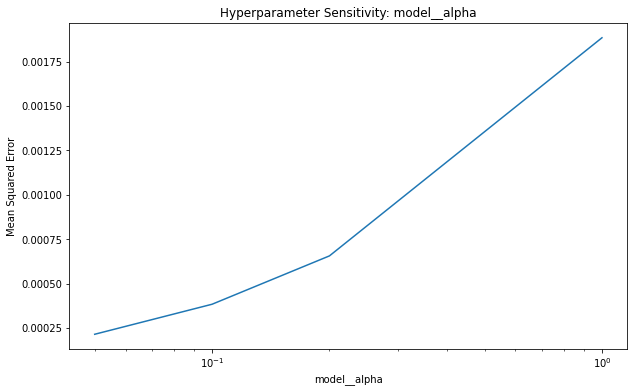


Ridge Regression_Validation_MSE: 0.0002, Ridge Regression_Validation_RMSE: 0.0146, Ridge Regression_Validation_MAE: 0.0111, Ridge Regression_Validation_R2: 0.9985
Ridge Regression_Test_MSE: 0.0107, Ridge Regression_Test_RMSE: 0.1035, Ridge Regression_Test_MAE: 0.0803, Ridge Regression_Test_R2: 0.9745


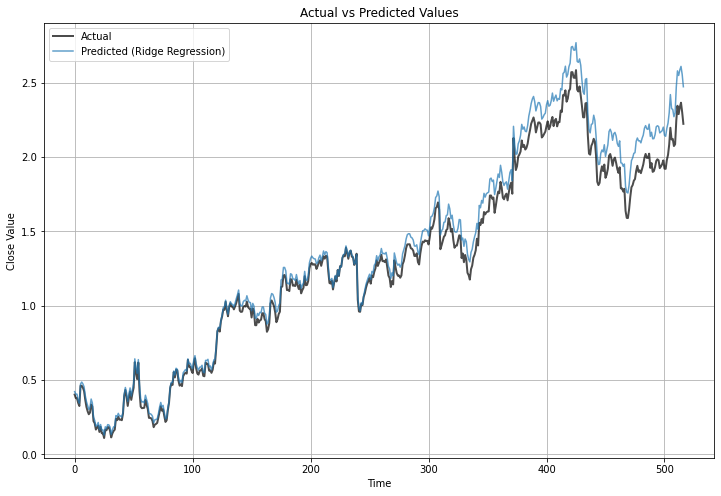

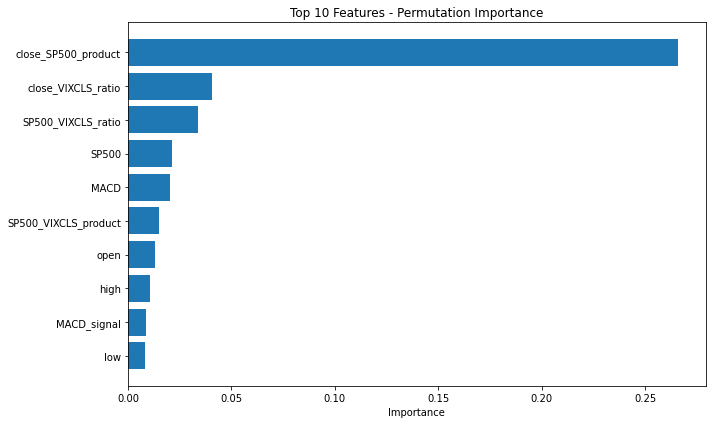


Feature Importances for Ridge Regression:
close_SP500_product > 0.02: 0.46404894559003745
SP500 > 0.29: 0.2843033736552443
high > 0.14: 0.20316570281059887
low > 0.14: 0.18986138187517546
close_SP500_ratio > 0.17: 0.17901955605787775
BB_upper > 0.11: 0.13187773009576156
MA20 > 0.15: 0.12384395425489868
BB_lower > 0.14: 0.11390188184764129
close_VIXCLS_ratio > -0.01: 0.10848275856116271
open > 0.14: -0.0831778177403763


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import lime
import lime.lime_tabular


# Function to plot Actual vs Predicted using Time Series Graph
def plot_actual_vs_predicted(models, X_test, y_test):
    plt.figure(figsize=(12, 8))

    # Plot actual values
    plt.plot(y_test.values, label='Actual', color='black', linewidth=2, alpha=0.7)

    # Plot predicted values for each model
    for model_name, model in models.items():
        y_pred_test = model.predict(X_test)
        plt.plot(y_pred_test, label=f'Predicted ({model_name})', alpha=0.7)

    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Close Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to train and evaluate models with hyperparameter tuning and time series split
def train_evaluate_model(model, X_train, y_train, X_val, y_val, param_grid=None, tscv=None):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle NaNs in the dataset
        ('model', model)
    ])

    # Perform Grid Search with TimeSeriesSplit if a parameter grid is provided
    if param_grid:
        search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        print(f"Best Parameters: {best_params}")

        # Hyperparameter Sensitivity Analysis
        results = pd.DataFrame(search.cv_results_)
        for param in param_grid:
            plt.figure(figsize=(10, 6))
            plt.plot(results[f'param_{param}'], -results['mean_test_score'])
            plt.xlabel(param)
            plt.ylabel('Mean Squared Error')
            plt.title(f'Hyperparameter Sensitivity: {param}')
            plt.xscale('log')
            plt.show()

    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline

    # Evaluate the model on the validation set
    y_pred_val = best_model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_r2 = r2_score(y_val, y_pred_val)

    return best_model, val_mse, val_rmse, val_mae, val_r2


def feature_importance_analysis(model, X_train, X_test, y_test):
    # Permutation feature importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Sort features by importance
    sorted_idx = perm_importance.importances_mean.argsort()

    # Select top 10 features
    top_10_idx = sorted_idx[-10:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(10), perm_importance.importances_mean[top_10_idx])
    plt.yticks(range(10), X_test.columns[top_10_idx])
    plt.title("Top 10 Features - Permutation Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Function to perform time series regression pipeline with model training and evaluation
def time_series_regression_pipeline(data, test_size=0.2):
    results = {}

    features = [col for col in data.columns if col not in ['close']]
    target = 'close'

    # Split data into train and test sets
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Split the training data further into training and validation sets
    train_size = int(len(X_train) * 0.8)  # 80% training and 20% validation
    X_train_split, X_val_split = X_train[:train_size], X_train[train_size:]
    y_train_split, y_val_split = y_train[:train_size], y_train[train_size:]

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    models = {
        'Ridge Regression': (Ridge(), {'model__alpha': [0.05, 0.1, 0.2, 1.0]})
    }

    # Store models for plotting
    trained_models = {}

    for model_name, (model, param_grid) in models.items():
        print(f"\nTraining {model_name} model...")
        best_model, val_mse, val_rmse, val_mae, val_r2 = train_evaluate_model(
            model, X_train_split, y_train_split, X_val_split, y_val_split, param_grid, tscv
        )

        # Evaluate the best model on the test set (hold-out dataset)
        y_pred_test = best_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)

        # Store results in the results dictionary (including validation and test results)
        results[model_name] = {
            'val_MSE': val_mse,
            'val_RMSE': val_rmse,
            'val_MAE': val_mae,
            'val_R2': val_r2,
            'test_MSE': test_mse,
            'test_RMSE': test_rmse,
            'test_MAE': test_mae,
            'test_R2': test_r2
        }

        # Store the trained model for plotting later
        trained_models[model_name] = best_model

    # Print results
    for model_name, metrics in results.items():
        print(f"\n{model_name}_Validation_MSE: {metrics['val_MSE']:.4f}, {model_name}_Validation_RMSE: {metrics['val_RMSE']:.4f}, "
              f"{model_name}_Validation_MAE: {metrics['val_MAE']:.4f}, {model_name}_Validation_R2: {metrics['val_R2']:.4f}")
        print(f"{model_name}_Test_MSE: {metrics['test_MSE']:.4f}, {model_name}_Test_RMSE: {metrics['test_RMSE']:.4f}, "
              f"{model_name}_Test_MAE: {metrics['test_MAE']:.4f}, {model_name}_Test_R2: {metrics['test_R2']:.4f}")

    # Plot Actual vs Predicted for each model
    plot_actual_vs_predicted(trained_models, X_test, y_test)

    feature_importance_analysis(best_model, X_train, X_test, y_test)

    explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train.values,
            feature_names=X_train.columns,
            class_names=['close'],
            mode='regression'
        )

        # Choose a random instance to explain
    instance = X_test.iloc[np.random.randint(0, len(X_test))].values

        # Generate the explanation
    exp = explainer.explain_instance(instance, best_model.predict, num_features=10)

        # Visualize the explanation
    exp.show_in_notebook(show_table=True)

    print(f"\nFeature Importances for {model_name}:")
    for feature, importance in exp.as_list():
        print(f"{feature}: {importance}")

    # Return the dictionary with results for further use if needed
    #return results
    return results, trained_models, X_test, y_test


# Assuming `df` is your DataFrame containing the time series data.
#final_results = time_series_regression_pipeline(df)
final_results, trained_models, X_test, y_test = time_series_regression_pipeline(df)

# Example to access metrics for Ridge model
ridge_val_rmse = final_results['Ridge Regression']['val_RMSE']
ridge_test_rmse = final_results['Ridge Regression']['test_RMSE']
ridge_val_mae = final_results['Ridge Regression']['val_MAE']
ridge_test_mae = final_results['Ridge Regression']['test_MAE']
ridge_val_r2 = final_results['Ridge Regression']['val_R2']
ridge_test_r2 = final_results['Ridge Regression']['test_R2']


### SVR

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


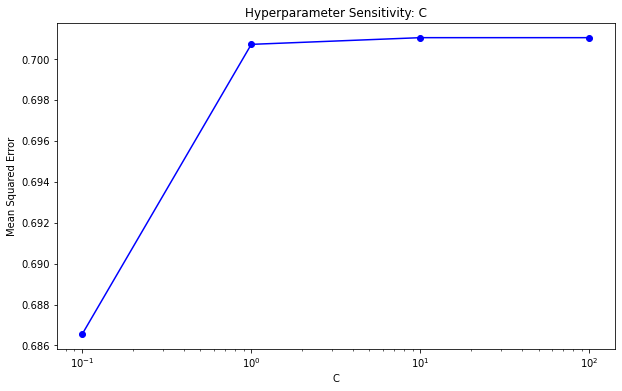

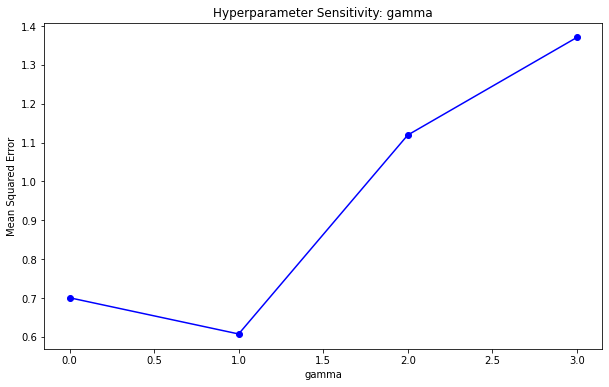

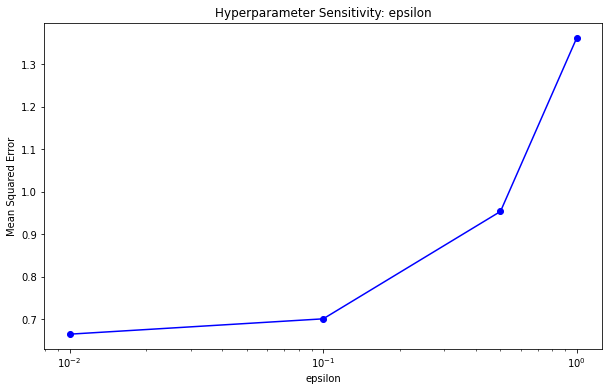

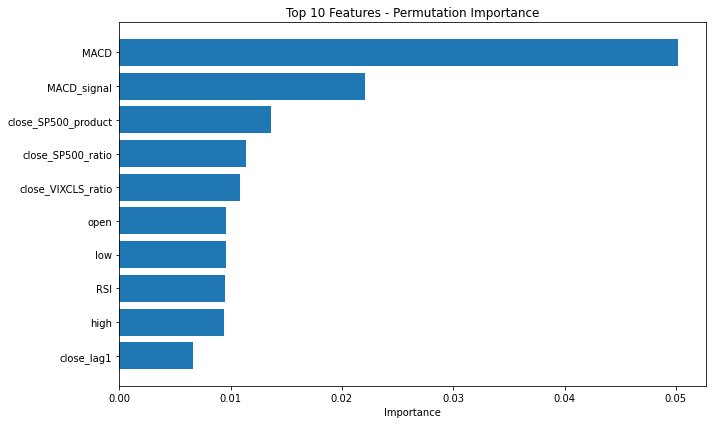

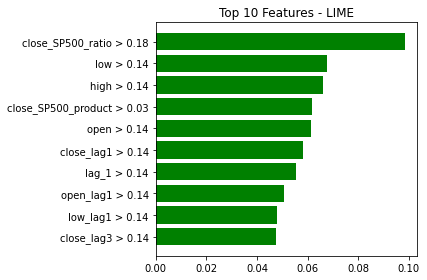

Validation RMSE: 0.0806, MAE: 0.0699, R²: 0.9581
Test RMSE: 0.1075, MAE: 0.0987, R²: 0.9165


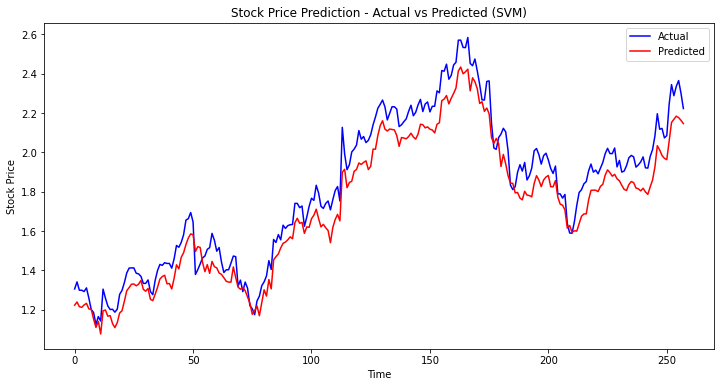

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import lime
import lime.lime_tabular
from sklearn.model_selection import cross_val_score

# Feature Engineering: Create lag features
def create_lag_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values
    return df

# Create lag features for time series prediction
lags = 10  # Example: Use the past 10 days as input features
df_lagged = create_lag_features(df, 'close', lags)

# Define features (X) and target (y)
X = df_lagged.drop('close', axis=1)
y = df_lagged['close']

# Split into train, validation, and test datasets (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Hyperparameter tuning for Support Vector Machine (SVM)
def hyperparameter_tuning(X_train, y_train):
    param_grid = {
        'C': [1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
        'epsilon': [0.1, 0.2, 0.5]
    }

    svr = SVR()
    grid_search = GridSearchCV(estimator=svr,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_params_

# Perform hyperparameter tuning
best_params = hyperparameter_tuning(X_train, y_train)


def hyperparameter_sensitivity(X_train, y_train):
    param_ranges = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'epsilon': [0.01, 0.1, 0.5, 1]
    }

    for param, values in param_ranges.items():
        scores = []
        for value in values:
            if param == 'gamma' and value in ['scale', 'auto']:
                svr = SVR(kernel='rbf', **{param: value})
            else:
                svr = SVR(kernel='rbf', **{param: float(value)})
            score = -np.mean(cross_val_score(svr, X_train, y_train, cv=3, scoring='neg_mean_squared_error'))
            scores.append(score)

        plt.figure(figsize=(10, 6))
        plt.plot(values, scores, 'bo-')
        plt.xlabel(param)
        plt.ylabel('Mean Squared Error')
        plt.title(f'Hyperparameter Sensitivity: {param}')
        plt.xscale('log' if param != 'gamma' else 'linear')
        plt.show()


# Train the model with the best parameters
def train_svm(X_train, y_train, params=None):
    model = SVR(**params) if params else SVR()
    model.fit(X_train, y_train)
    return model

# Train the model using the best hyperparameters
model = train_svm(X_train, y_train, params=best_params)


def feature_importance_analysis(model, X_train, X_test, feature_names):
    # Permutation Importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()
    top_10_idx = sorted_idx[-10:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(10), perm_importance.importances_mean[top_10_idx])
    plt.yticks(range(10), [feature_names[i] for i in top_10_idx])
    plt.title("Top 10 Features - Permutation Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # LIME
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names, mode="regression")
    exp = explainer.explain_instance(X_test.iloc[0], model.predict, num_features=10)
    exp.as_pyplot_figure()
    plt.title("Top 10 Features - LIME")
    plt.tight_layout()
    plt.show()


# Evaluate the model
def evaluate_model(model, X_val, y_val, X_test, y_test):
    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    svm_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    svm_val_mae = mean_absolute_error(y_val, y_val_pred)
    svm_val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {svm_val_rmse:.4f}, MAE: {svm_val_mae:.4f}, R²: {svm_val_r2:.4f}")

    # Evaluate on test set
    y_test_pred = model.predict(X_test)
    svm_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    svm_test_mae = mean_absolute_error(y_test, y_test_pred)
    svm_test_r2 = r2_score(y_test, y_test_pred)

    print(f"Test RMSE: {svm_test_rmse:.4f}, MAE: {svm_test_mae:.4f}, R²: {svm_test_r2:.4f}")

    # Plot Actual vs Predicted (Test Set)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label="Actual", color='blue')
    plt.plot(y_test_pred, label="Predicted", color='red')
    plt.title("Stock Price Prediction - Actual vs Predicted (SVM)")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    # Return metrics as a dictionary for later use
    return {
        'Val_RMSE': svm_val_rmse,
        'Val_MAE': svm_val_mae,
        'Val_R²': svm_val_r2,
        'Test_RMSE': svm_test_rmse,
        'Test_MAE': svm_test_mae,
        'Test_R²': svm_test_r2,
        'Val_Predictions': y_val_pred,
        'Test_Predictions': y_test_pred
    }

# Perform hyperparameter sensitivity analysis
hyperparameter_sensitivity(X_train, y_train)

# Perform feature importance analysis
feature_names = X_train.columns.tolist()
feature_importance_analysis(model, X_train, X_test, feature_names)
# Evaluate the trained model
results = evaluate_model(model, X_val, y_val, X_test, y_test)

# Access metrics outside the function
svm_val_rmse = results['Val_RMSE']
svm_val_mae = results['Val_MAE']
svm_val_r2 = results['Val_R²']
svm_test_rmse = results['Test_RMSE']
svm_test_mae = results['Test_MAE']
svm_test_r2 = results['Test_R²']
y_val_pred = results['Val_Predictions']
y_test_pred = results['Test_Predictions']

### LSTM

Training with timesteps=30, units=50, dropout=0.2, batch_size=16
8/8 [==============================] - 1s 9ms/step
Training with timesteps=30, units=50, dropout=0.2, batch_size=32
8/8 [==============================] - 1s 6ms/step
Best Hyperparameters: {'timesteps': 30, 'units': 50, 'dropout_rate': 0.2, 'batch_size': 32}

Evaluating the best model with both validation and test data...

8/8 [==============================] - 0s 5ms/step
Validation RMSE: 0.0880, MAE: 0.0669, R2: 0.9504
Test RMSE: 0.1180, MAE: 0.0989, R2: 0.8987


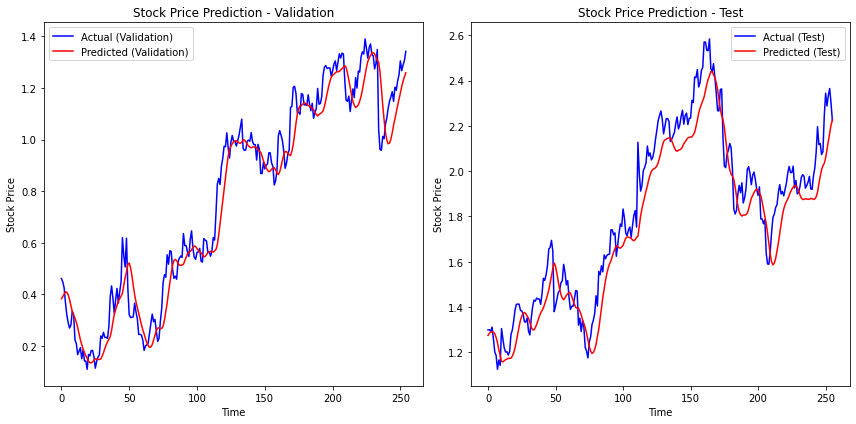

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K


# Assuming df is your DataFrame with stock price data (with 'date' and 'close' columns)
dff = df.copy()
# Ensure 'close' is the target variable and convert the 'date' column to datetime if it's not already
dff.reset_index('date', inplace=True)  # Set the date as the index
dff = dff[['close']]  # Use only the 'close' column for prediction

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dff)

# Create sequences for LSTM (using a sliding window approach)
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i - timesteps:i, 0])  # timesteps previous data points (inputs)
        y.append(data[i, 0])  # Target is the 'close' price of the current day (output)
    return np.array(X), np.array(y)

# Define function to preprocess data and split into train, validation, and test sets
def preprocess_data(df, timesteps):
    data = df_scaled
    X, y = create_sequences(data, timesteps)

    # Split into training, validation, and testing datasets (80% train, 10% validation, 10% test)
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    # Reshape X data for LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the LSTM model
def build_lstm_model(input_shape, units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Hyperparameter tuning function
def hyperparameter_tuning(df, timesteps_options, units_options, dropout_options, batch_size_options, epochs=20):
    best_model = None
    best_rmse = float('inf')
    best_hyperparams = {}

    # Preprocess data and create validation set (separate from training)
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, timesteps_options[0])

    for timesteps in timesteps_options:
        for units in units_options:
            for dropout_rate in dropout_options:
                for batch_size in batch_size_options:
                    print(f"Training with timesteps={timesteps}, units={units}, dropout={dropout_rate}, batch_size={batch_size}")

                    # Build the model
                    model = build_lstm_model(X_train.shape[1:], units, dropout_rate)

                    # Train the model
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

                    # Evaluate on validation set
                    y_val_pred_scaled = model.predict(X_val)
                    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
                    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                    # Store the best model
                    if val_rmse < best_rmse:
                        best_rmse = val_rmse
                        best_model = model
                        best_hyperparams = {
                            'timesteps': timesteps,
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size
                        }

    print(f"Best Hyperparameters: {best_hyperparams}")
    return best_model, best_hyperparams, best_rmse

# Evaluate the model performance on both validation and test datasets
def evaluate_model(model, df, timesteps, scaler):
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, timesteps)

    # Predict on the validation set (hold-out validation)
    y_val_pred_scaled = model.predict(X_val)
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))

    # Predict on the test set
    y_test_pred_scaled = model.predict(X_test)
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate metrics for validation set
    lstm_val_rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
    lstm_val_mae = mean_absolute_error(y_val_orig, y_val_pred)
    lstm_val_r2 = r2_score(y_val_orig, y_val_pred)

    # Evaluate metrics for test set
    lstm_test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
    lstm_test_mae = mean_absolute_error(y_test_orig, y_test_pred)
    lstm_test_r2 = r2_score(y_test_orig, y_test_pred)

    # Print results
    print(f"Validation RMSE: {lstm_val_rmse:.4f}, MAE: {lstm_val_mae:.4f}, R2: {lstm_val_r2:.4f}")
    print(f"Test RMSE: {lstm_test_rmse:.4f}, MAE: {lstm_test_mae:.4f}, R2: {lstm_test_r2:.4f}")

    # Plot Actual vs Predicted values for both validation and test sets
    plt.figure(figsize=(12, 6))

    # Validation Plot
    plt.subplot(1, 2, 1)
    plt.plot(y_val_orig, label="Actual (Validation)", color='blue')
    plt.plot(y_val_pred, label="Predicted (Validation)", color='red')
    plt.title("Stock Price Prediction - Validation")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()

    # Test Plot
    plt.subplot(1, 2, 2)
    plt.plot(y_test_orig, label="Actual (Test)", color='blue')
    plt.plot(y_test_pred, label="Predicted (Test)", color='red')
    plt.title("Stock Price Prediction - Test")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return the evaluation metrics for both sets
    return lstm_val_rmse, lstm_val_mae, lstm_val_r2, lstm_test_rmse, lstm_test_mae, lstm_test_r2


# Set hyperparameters for tuning
timesteps_options = [30]  # [30, 60, 90]
units_options = [50]  # [50, 100, 150]
dropout_options = [0.2]  # [0.2, 0.3, 0.4]
batch_size_options = [16, 32]  # [16, 32, 64]

# Run hyperparameter tuning
best_model, best_hyperparams, LSTM_val_rmse = hyperparameter_tuning(df, timesteps_options, units_options, dropout_options, batch_size_options)

# Evaluate the best model using validation and test results
print("\nEvaluating the best model with both validation and test data...\n")
lstm_val_rmse, lstm_val_mae, lstm_val_r2, lstm_test_rmse, lstm_test_mae, lstm_test_r2 = evaluate_model(best_model, df, best_hyperparams['timesteps'], scaler)

### Pick Best Model & Model Bias Detection 

In [8]:
def select_best_model(models_metrics):

    # Initialize variables to track the best model
    best_model_name = None
    best_model_metrics = None
    best_rmse = float('inf')  # Start with a large number to compare RMSE

    # Iterate through the dictionary of models and their metrics
    for model_name, metrics in models_metrics.items():
        # Get RMSE for the current model
        model_rmse = metrics.get('RMSE')

        # Check if the current RMSE is the best
        if model_rmse < best_rmse:
            best_rmse = model_rmse
            best_model_name = model_name
            best_model_metrics = metrics

    return best_model_name, best_model_metrics

# Example usage:
models_metrics = {
    'SVM': {'RMSE': svm_test_rmse, 'MAE': svm_test_mae},
    'Ridge Regression': {'RMSE': ridge_test_rmse, 'MAE': ridge_test_mae},
}

# Select the best model based on RMSE
best_model_name, best_model_metrics = select_best_model(models_metrics)

print(f"The best model is {best_model_name} with metrics: {best_model_metrics}")


The best model is Ridge Regression with metrics: {'RMSE': 0.10354173424124137, 'MAE': 0.08029121077552018}



Best Model for Bias Detection: Ridge Regression
                      MSE      RMSE       MAE        R²
High Volume      0.000861  0.029334  0.010654  0.998803
Low Volume       0.005207  0.072159  0.036153    0.9958
Overbought           None      None      None      None
Oversold         0.002186  0.046757  0.019157  0.997814
Bullish Market   0.005008  0.070766  0.041548  0.987835
High Volatility  0.002027  0.045023  0.016813  0.997225


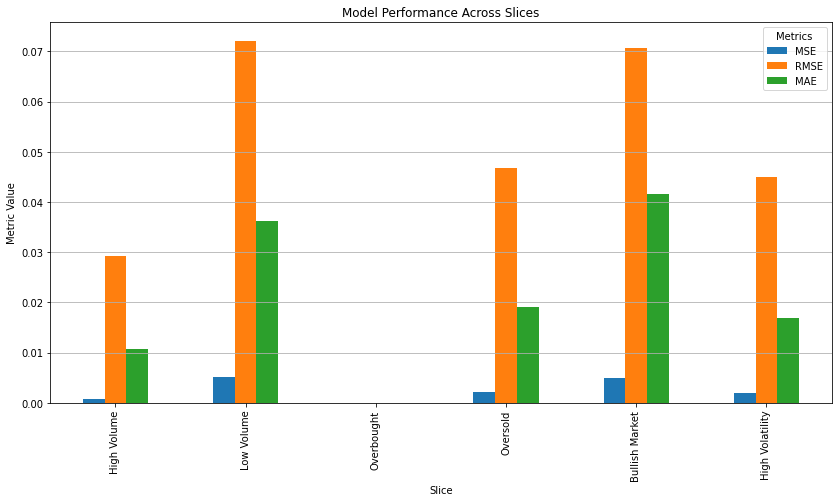

Validating Supporting Evidence for No Bias:

Consistent R² Across Slices: Passed
Low Error Metrics: Passed
No Missing Data Bias: Passed

Conclusion: The model shows no significant bias across all the slices. 


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def define_slices(df):
    """
    Define meaningful slices of the dataset based on domain-specific criteria.

    Parameters:
    df (pd.DataFrame): The input dataset.

    Returns:
    dict: A dictionary of slices with slice names as keys and sliced data as values.
    """
    high_volume = df[df['volume'] > df['volume'].quantile(0.75)]  # Top 25% volume
    low_volume = df[df['volume'] <= df['volume'].quantile(0.25)]  # Bottom 25% volume

    # RSI slices
    overbought = df[df['RSI'] > 70]  # Overbought
    oversold = df[df['RSI'] < 30]   # Oversold

    # Market condition slices
    bullish_market = df[df['SP500'] > df['SP500'].mean()]  # Bullish market
    high_volatility = df[df['VIXCLS'] > df['VIXCLS'].mean()]  # High volatility

    # Combine slices into a dictionary
    slices = {
        'High Volume': high_volume,
        'Low Volume': low_volume,
        'Overbought': overbought,
        'Oversold': oversold,
        'Bullish Market': bullish_market,
        'High Volatility': high_volatility
    }

    return slices


def evaluate_slice(slice_data, model, X_columns, y_column):
    """
    Evaluate regression metrics for a given slice.

    Parameters:
    slice_data (pd.DataFrame): The subset of data for the slice.
    model: The trained regression model.
    X_columns (list): The feature columns used for prediction.
    y_column (str): The target variable.

    Returns:
    dict: Metrics (MSE, RMSE, MAE, R²) for the slice.
    """
    # Ensure slice has sufficient data
    if len(slice_data) < 10:  # Skip slices with too few samples
        return {'MSE': None, 'RMSE': None, 'MAE': None, 'R²': None}

    # Split slice data into features and target
    X_slice = slice_data[X_columns]
    y_slice = slice_data[y_column]

    # Predict target
    y_pred_slice = model.predict(X_slice)

    # Calculate metrics
    mse = mean_squared_error(y_slice, y_pred_slice)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_slice, y_pred_slice)
    r2 = r2_score(y_slice, y_pred_slice)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}


def calculate_metrics_for_slices(slices, model, X_columns, y_column):
    """
    Calculate metrics for each slice of the dataset.

    Parameters:
    slices (dict): Dictionary of slices.
    model: The trained regression model.
    X_columns (list): The feature columns used for prediction.
    y_column (str): The target variable.

    Returns:
    dict: Metrics for each slice.
    """
    metrics_by_slice = {}
    for slice_name, slice_data in slices.items():
        metrics_by_slice[slice_name] = evaluate_slice(slice_data, model, X_columns, y_column)
    return metrics_by_slice


def visualize_metrics(metrics_by_slice):
    """
    Visualize metrics for each slice as a bar chart.

    Parameters:
    metrics_by_slice (dict): Metrics for each slice.

    Returns:
    None
    """
    metrics_df = pd.DataFrame(metrics_by_slice).T  # Transpose for easier viewing
    print(metrics_df)

    # Visualize metrics
    metrics_df[['MSE', 'RMSE', 'MAE']].plot(kind='bar', figsize=(14, 7))
    plt.title('Model Performance Across Slices')
    plt.ylabel('Metric Value')
    plt.xlabel('Slice')
    plt.legend(title='Metrics')
    plt.grid(axis='y')
    plt.show()


def compare_to_overall(metrics_by_slice, overall_metrics, threshold=2):
    """
    Compare slice metrics to overall metrics to identify significant disparities.

    Parameters:
    metrics_by_slice (dict): Metrics for each slice.
    overall_metrics (dict): Overall metrics for the dataset.
    threshold (float): Threshold for significant disparity. Default is 2x the overall metric.

    Returns:
    None
    """
    print("\nSignificant disparities compared to overall metrics:")
    for slice_name, slice_metrics in metrics_by_slice.items():
        for metric, value in slice_metrics.items():
            if value and value > threshold * overall_metrics[metric]:  # Example threshold: 2x overall metric
                print(f"Significant disparity in {slice_name} for {metric}: {value}")


def validate_evidence(metrics_by_slice, overall_metrics, threshold=2):
    """
    Validate evidence for no bias based on defined criteria.

    Parameters:
    metrics_by_slice (dict): Metrics calculated for each slice.
    overall_metrics (dict): Overall metrics for the entire dataset.
    threshold (float): Threshold for significant deviation. Default is 2x the overall metric.

    Returns:
    dict: A dictionary of evidence validation results.
    """
    evidence_results = {}

    # 1. Consistent R² Across Slices
    consistent_r2 = True
    for slice_name, slice_metrics in metrics_by_slice.items():
        if slice_metrics['R²'] is not None and slice_metrics['R²'] < 0.95:  # Assuming 0.95 as a high R² threshold
            consistent_r2 = False
            break
    evidence_results['Consistent R² Across Slices'] = consistent_r2

    # 2. Low Error Metrics
    low_error = True
    for slice_name, slice_metrics in metrics_by_slice.items():
        for metric in ['MSE', 'RMSE', 'MAE']:
            if (
                slice_metrics[metric] is not None
                and slice_metrics[metric] > threshold * overall_metrics[metric]
            ):
                # Minor issue: If failures occur in only one or two low-representation slices
                if len(slice_metrics) < 10:  # Skip if underrepresented
                    has_minor_issues = True
                else:
                    low_error = False
    evidence_results['Low Error Metrics'] = low_error

    # 3. No Missing Data Bias
    no_missing_data_bias = True
    missing_slices = []
    for slice_name, slice_metrics in metrics_by_slice.items():
        if all(value is None for value in slice_metrics.values()):  # Check if all metrics are None
            missing_slices.append(slice_name)
            no_missing_data_bias = False

    # If missing slices are due to underrepresented data, treat them as minor issues
    if len(missing_slices) <= 2:  # Example: Allow up to 2 slice to be missing
        has_minor_issues = True
        no_missing_data_bias = True  # Downgrade to minor issue
    evidence_results['No Missing Data Bias'] = no_missing_data_bias

    return evidence_results


def print_evidence_results(evidence_results):
    """
    Print the validation results of each evidence.
    """
    print("Validating Supporting Evidence for No Bias:\n")
    for evidence, result in evidence_results.items():
        print(f"{evidence}: {'Passed' if result else 'Failed'}")


# Select the best model dynamically
best_model_name = min(final_results, key=lambda model: final_results[model]['test_RMSE'])
best_model = trained_models[best_model_name]
print(f"\nBest Model for Bias Detection: {best_model_name}")

# Define slices
slices = define_slices(df)

# Get feature columns and target
features = [col for col in df.columns if col != 'close']  # Exclude target column
target = 'close'

# Evaluate metrics for each slice
metrics_by_slice = calculate_metrics_for_slices(slices, best_model, features, target)

# Visualize slice metrics
visualize_metrics(metrics_by_slice)

# Evaluate overall metrics for the best model
overall_metrics = evaluate_slice(df, best_model, X_columns=features, y_column=target)

# Validate evidence for bias
evidence_results = validate_evidence(metrics_by_slice, overall_metrics)

# Print evidence results
print_evidence_results(evidence_results)

# Final Check for Bias
if all(evidence_results.values()):
    print("\nConclusion: The model shows no significant bias across all the slices. ")
else:
    print("\nConclusion: The model shows potential bias.")

                      MSE      RMSE       MAE        R²
High Volume      0.000861  0.029334  0.010654  0.998803
Low Volume       0.005207  0.072159  0.036153    0.9958
Overbought           None      None      None      None
Oversold         0.002186  0.046757  0.019157  0.997814
Bullish Market   0.005008  0.070766  0.041548  0.987835
High Volatility  0.002027  0.045023  0.016813  0.997225


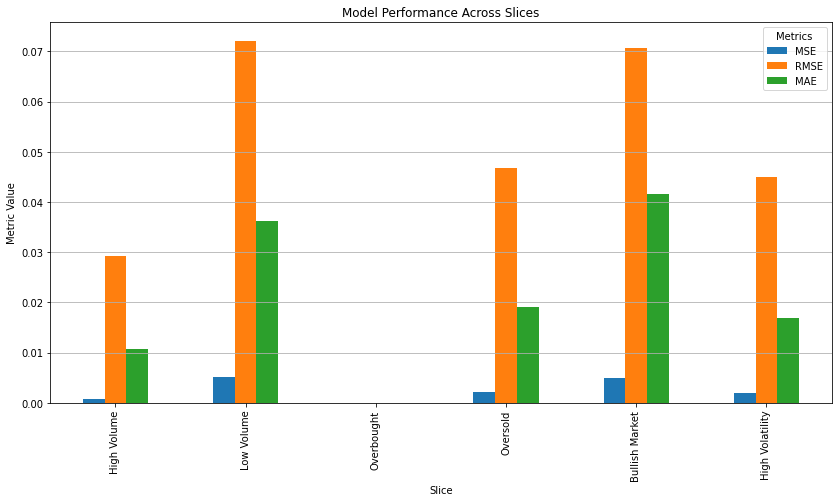

In [10]:
# Visualize slice metrics
visualize_metrics(metrics_by_slice)

  - Consistent R² Across Slices: The R² scores are consistently very high (close to 1) across all slices, which means the model is doing a good job of explaining the variance in the target variable, regardless of the different conditions.

  - Low Error Metrics: Although the error metrics (MSE, RMSE, MAE) vary a bit between slices, these differences are small and fall within reasonable limits. There’s no sign of any significant underperformance in any specific slice.

  - No Missing Data Bias: The only slice without metrics (Overbought) is simply due to a lack of data in that slice, not because of an issue with the model itself.
